In [2]:
import numpy as np
import glob
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# prepare object points
nx = 9
ny = 6

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    cal_img = mpimg.imread(fname)
    gray = cv2.cvtColor(cal_img,cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(cal_img, (nx,ny), corners, ret)
#         plt.imshow(img)

#Get the calibration matrix stuff
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

#Use the calibration matrix stuff to undistort an image
dst = cv2.undistort(cal_img, mtx, dist, None, mtx)
plt.imshow(dst)

In [3]:
def undistort(img):
    # variables come from previously run code
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

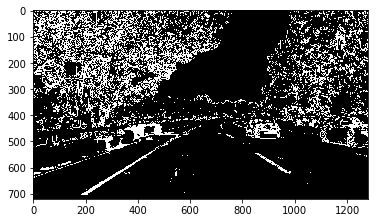

In [4]:
# Use color transforms, gradients, etc., to create a thresholded binary image.
def binary_pipeline(img, s_thresh=(160, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the s channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    
    # Combine the binary images
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary
    
# Test the function
img = mpimg.imread('test_images/test5.jpg')
# img = mpimg.imread('output_images/test_image.jpg')
dst = cv2.undistort(img, mtx, dist, None, mtx)
binary_img = binary_pipeline(dst)
plt.imshow(binary_img, cmap = 'gray')
plt.imsave("output_images/binary_img.jpeg", binary_img, cmap = 'gray')

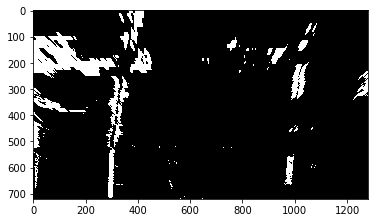

In [5]:
# Apply a perspective transform to rectify binary image ("birds-eye view").
def perspective_transform(binary_img, reverse):
    # Choose the points based on the straight line pictures
    src = np.float32([[580,460], [203, 720] , [1120, 720], [705, 460]])
    dst = np.float32([[320, 0], [320, 720], [960, 720],  [960, 0]])

    # Have an option to do the perspective transform in reverse, to plot the lane lines on the main image
    if (reverse==1):
        M = cv2.getPerspectiveTransform(dst, src)
    else:
        M = cv2.getPerspectiveTransform(src, dst)
    
    # Do the perspective transform
    img_size = (binary_img.shape[1], binary_img.shape[0])
    warped = cv2.warpPerspective(binary_img, M, img_size, flags=cv2.INTER_LINEAR)

    return warped

# Test the function
warped = perspective_transform(binary_img, 0)
plt.imshow(warped, cmap = 'gray')
plt.imsave("output_images/warped_image.jpeg", warped, cmap = 'gray')

In [6]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 

# Create the Line class for the left and right lines
left_line = Line()
right_line = Line()

In [7]:
# Detect lane pixels and fit to find the lane boundary
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Number of sliding windows
    nwindows = 9 # 9
    # Set the width of the windows +/- margin
    margin = 100 #100
    # Set minimum number of pixels found to recenter window
    minpix = 40 # 50?

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin  
        win_xleft_high = leftx_current + margin 
        win_xright_low = rightx_current - margin 
        win_xright_high = rightx_current + margin

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high) &
        (nonzeroy >= win_y_low) & (nonzeroy < win_y_high)).nonzero()[0]
        good_right_inds = ((nonzerox >= win_xright_low) & (nonzerox < win_xright_high) &
        (nonzeroy >= win_y_low) & (nonzeroy < win_y_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # If > minpix pixels, recenter next window
        # (`right` or `leftx_current`) on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit` 
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # If there was a fit, save it to the classes and set detected = True. Otherwise, Detected = False
    if (left_fit[0] != 0) & (left_fit[1] != 0) & (left_fit[2] != 0):
        left_line.current_fit = left_fit
        left_line.detected = True
    else:
        left_line.detected = False
    if (right_fit[0] != 0) & (right_fit[1] != 0) & (right_fit[2] != 0):
        right_line.current_fit = right_fit
        right_line.detected = True
    else:
        right_line.detected = False

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
      

    ## Visualization ##
    # Colors in the left and right lane regions
    new_img = np.dstack((binary_warped, binary_warped, binary_warped))
    new_img[lefty, leftx] = [255,0,0]
    new_img[righty, rightx] = [0,0,255]
    
    # Plot the lane as green
    grid = np.mgrid[0:720,0:1280]
    gridx = grid[0]
    gridy = grid[1]
    lane_inds = (gridy >= (left_fit[0]*gridx**2 + left_fit[1]*gridx + 
    left_fit[2])) & (gridy < (right_fit[0]*gridx**2 + right_fit[1]*gridx
    + right_fit[2]))
    lane_marked = np.zeros((binary_warped.shape[0], binary_warped.shape[1], 3), dtype = np.uint8)
    lane_marked[lane_inds] = (0,255,0)
    
    # combine the two images
    out_img = new_img + lane_marked
    
    return out_img

In [8]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    # Fit a second order polynomial to each with np.polyfit()
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # If there was a fit, save it to the classes and set detected = True. Otherwise, Detected = False
    if (left_fit[0] != 0) & (left_fit[1] != 0) & (left_fit[2] != 0):
        left_line.current_fit = left_fit
        left_line.detected = True
    else:
        left_line.detected = False
    if (right_fit[0] != 0) & (right_fit[1] != 0) & (right_fit[2] != 0):
        right_line.current_fit = right_fit
        right_line.detected = True
    else:
        right_line.detected = False
    
    return left_fit, right_fit

def search_around_poly(binary_warped):
    # HYPERPARAMETER
    # The width of the margin around the previous polynomial to search
    margin = 30

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Bring in previous fit values:
    left_fit = left_line.current_fit
    right_fit = right_line.current_fit
    
    # Set the area of search based on activated x-values 
    # within the +/- margin of our polynomial function  
    left_lane_inds = (nonzerox >= (left_fit[0]*nonzeroy**2 + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*nonzeroy**2 + left_fit[1]*nonzeroy
    + left_fit[2] + margin))
    right_lane_inds = (nonzerox >= (right_fit[0]*nonzeroy**2 + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*nonzeroy**2 + right_fit[1]*nonzeroy
    + right_fit[2] + margin))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fit_new, right_fit_new = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)

    # Plot the lane lines
    new_img = np.zeros_like(out_img)
    new_img[lefty, leftx] = [255, 0 ,0]
    new_img[righty, rightx] = [0,0,255]
    
    # Plot the lane as green
    grid = np.mgrid[0:720,0:1280]
    gridx = grid[0]
    gridy = grid[1]
    lane_inds = (gridy >= (left_fit_new[0]*gridx**2 + left_fit_new[1]*gridx + 
    left_fit_new[2])) & (gridy < (right_fit_new[0]*gridx**2 + right_fit_new[1]*gridx
    + right_fit_new[2]))
    lane_marked = np.zeros((binary_warped.shape[0], binary_warped.shape[1], 3), dtype = np.uint8)
    lane_marked[lane_inds] = (0,255,0)
    
    result = lane_marked + new_img
    
    return result

In [9]:
def curvature_and_position(img):
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    y_eval = 719
    left_fit = left_line.current_fit
    right_fit = right_line.current_fit
    left_curverad = (1+(2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**(1.5) / (np.absolute(2*left_fit[0]))
    right_curverad = (1+(2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**(1.5) / (np.absolute(2*right_fit[0]))
    left_line.radius_of_curvature = left_curverad
    right_line.radius_of_curvature = right_curverad
 
    curv = np.mean((left_curverad, right_curverad))
    
    # Find the position of the car relative to the lane center
    # Find the center of the image
    center = img.shape[1]/2 * xm_per_pix
    # Find the position of the lane lines at the bottom of the image
    left_lane_pos = (left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2])*xm_per_pix
    right_lane_pos = (right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2])*xm_per_pix
    pos = (right_lane_pos + left_lane_pos)/2 - center

    right_line.line_base_pos = pos
    left_line.line_base_pos = pos

    return curv, pos

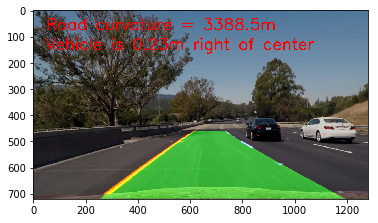

In [10]:
# Process Image code for testing purposes
img = mpimg.imread('test_images/test6.jpg')
dst = undistort(img)
plt.imsave("output_images/undistorted_road.jpeg", dst)
# - Use color transforms, gradients, etc., to create a thresholded binary image.
binary_img = binary_pipeline(dst)

# - Apply a perspective transform to rectify binary image ("birds-eye view").
warped = perspective_transform(binary_img, 0)

# - Detect lane pixels and fit to find the lane boundary.
if (left_line.detected == False) | (right_line.detected == False):
    out_img = fit_polynomial(warped)
else:
    out_img = search_around_poly(warped)
    
# - Determine the curvature of the lane and vehicle position with respect to center.
if (left_line.detected) & (right_line.detected):
    curv, pos = curvature_and_position(out_img)
else:
    curv = 0
    pos = 0
    
# - Warp the detected lane boundaries back onto the original image.
rewarped = perspective_transform(out_img, 1)

# Overlay it onto the main image
combo = cv2.addWeighted(rewarped, 0.5, dst, 0.8, 0)
plt.imsave("output_images/lane_marked.jpeg", combo)

# - Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
cv2.putText(combo, 'Road curvature = %.1fm' % (curv), (50,75), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,0,0), 3, cv2.LINE_AA)
if pos>0:
    cv2.putText(combo, 'Vehicle is %.2fm right of center' % (pos), (50,150), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,0,0), 3, cv2.LINE_AA)
else:
    cv2.putText(combo, 'Vehicle is %.2fm left of center' % (-1*pos), (50,150), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,0,0), 3, cv2.LINE_AA)
plt.imshow(combo)
plt.imsave("output_images/final_image.jpeg", combo)

In [11]:
left_line.detected = False
right_line.detected = False

In [12]:
def process_image(image):
    
    # save an image for future testing
#     plt.imsave('output_images/test_image.jpg', image)
    
    # - Apply a distortion correction to raw images.
    dst = undistort(image)
    
    # - Use color transforms, gradients, etc., to create a thresholded binary image.
    binary_img = binary_pipeline(dst)
    
    # - Apply a perspective transform to rectify binary image ("birds-eye view").
    warped = perspective_transform(binary_img, 0)
    
    # - Detect lane pixels and fit to find the lane boundary.
    if (left_line.detected == False) | (right_line.detected == False):
        out_img = fit_polynomial(warped)
    else:
        out_img = search_around_poly(warped)

    # - Determine the curvature of the lane and vehicle position with respect to center.
    curv, pos = curvature_and_position(out_img)

    # - Warp the detected lane boundaries back onto the original image.
    rewarped = perspective_transform(out_img, 1)
    
    # - Overlay it onto the main image
    combo = cv2.addWeighted(rewarped, 0.5, dst, 0.8, 0)

    # - Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
    cv2.putText(combo, 'Road curvature = %.1fm' % (curv), (50,75), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,0,0), 3, cv2.LINE_AA)
    if pos>0:
        cv2.putText(combo, 'Vehicle is %.2fm right of center' % (pos), (50,150), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,0,0), 3, cv2.LINE_AA)
    else:
        cv2.putText(combo, 'Vehicle is %.2fm left of center' % (-1*pos), (50,150), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,0,0), 3, cv2.LINE_AA)

    return combo

In [13]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [16]:
left_line.detected = False
right_line.detected = False
white_output = 'project_video_output.mp4'
# white_output = 'challenge_video_output2.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
# clip1 = VideoFileClip("project_video.mp4").subclip(20,27)
clip1 = VideoFileClip("project_video.mp4")
# clip1 = VideoFileClip("challenge_video.mp4")#.subclip(10,12)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [05:48<00:00,  3.63it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 2min 51s, sys: 56.4 s, total: 3min 47s
Wall time: 5min 51s


In [19]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))